## Set up

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import tqdm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 34.6 MB/s eta 0:00:00


In [3]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 16.1 MB/s eta 0:00:00


In [4]:
import pytorch_lightning as pl
from torchmetrics import Accuracy

<h3 align="center">Task N1 - NN training with torch</h3>

- **Fully connected neural networks** are the foundation of deep learning models. Able to learn any function they are powerful estimators. While it's easy to build and train neural network, debugging it becomes harder and harder more complex the network becomes. Forward and backward pass might run but there could be some other mathematical error which keeps network from learning.

- To get the dataset use the code below:
```
import pandas as pd
col_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
data = pd.read_csv(url, header=None, names=col_names)
```

In [63]:
col_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
data = pd.read_csv(url, header=None, names=col_names)

In [64]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


- Your task is to train a binary classification network with binary cross entropy loss for predicting diabetes. Train your network with torch and with pytorch-lightning, explain your findings, reason around the network's performance, try different hyperparameters/network architecture setups

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [66]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


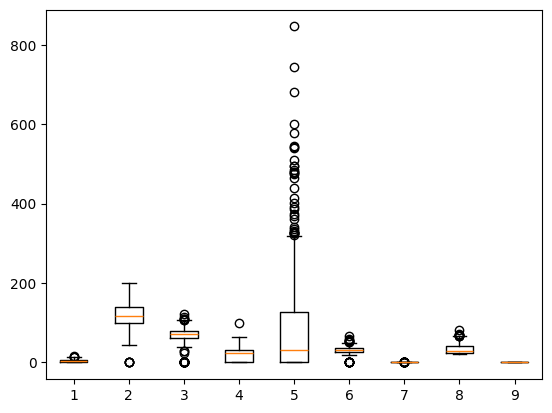

In [68]:
plt.boxplot(data)
plt.show()

<Figure size 400x400 with 0 Axes>

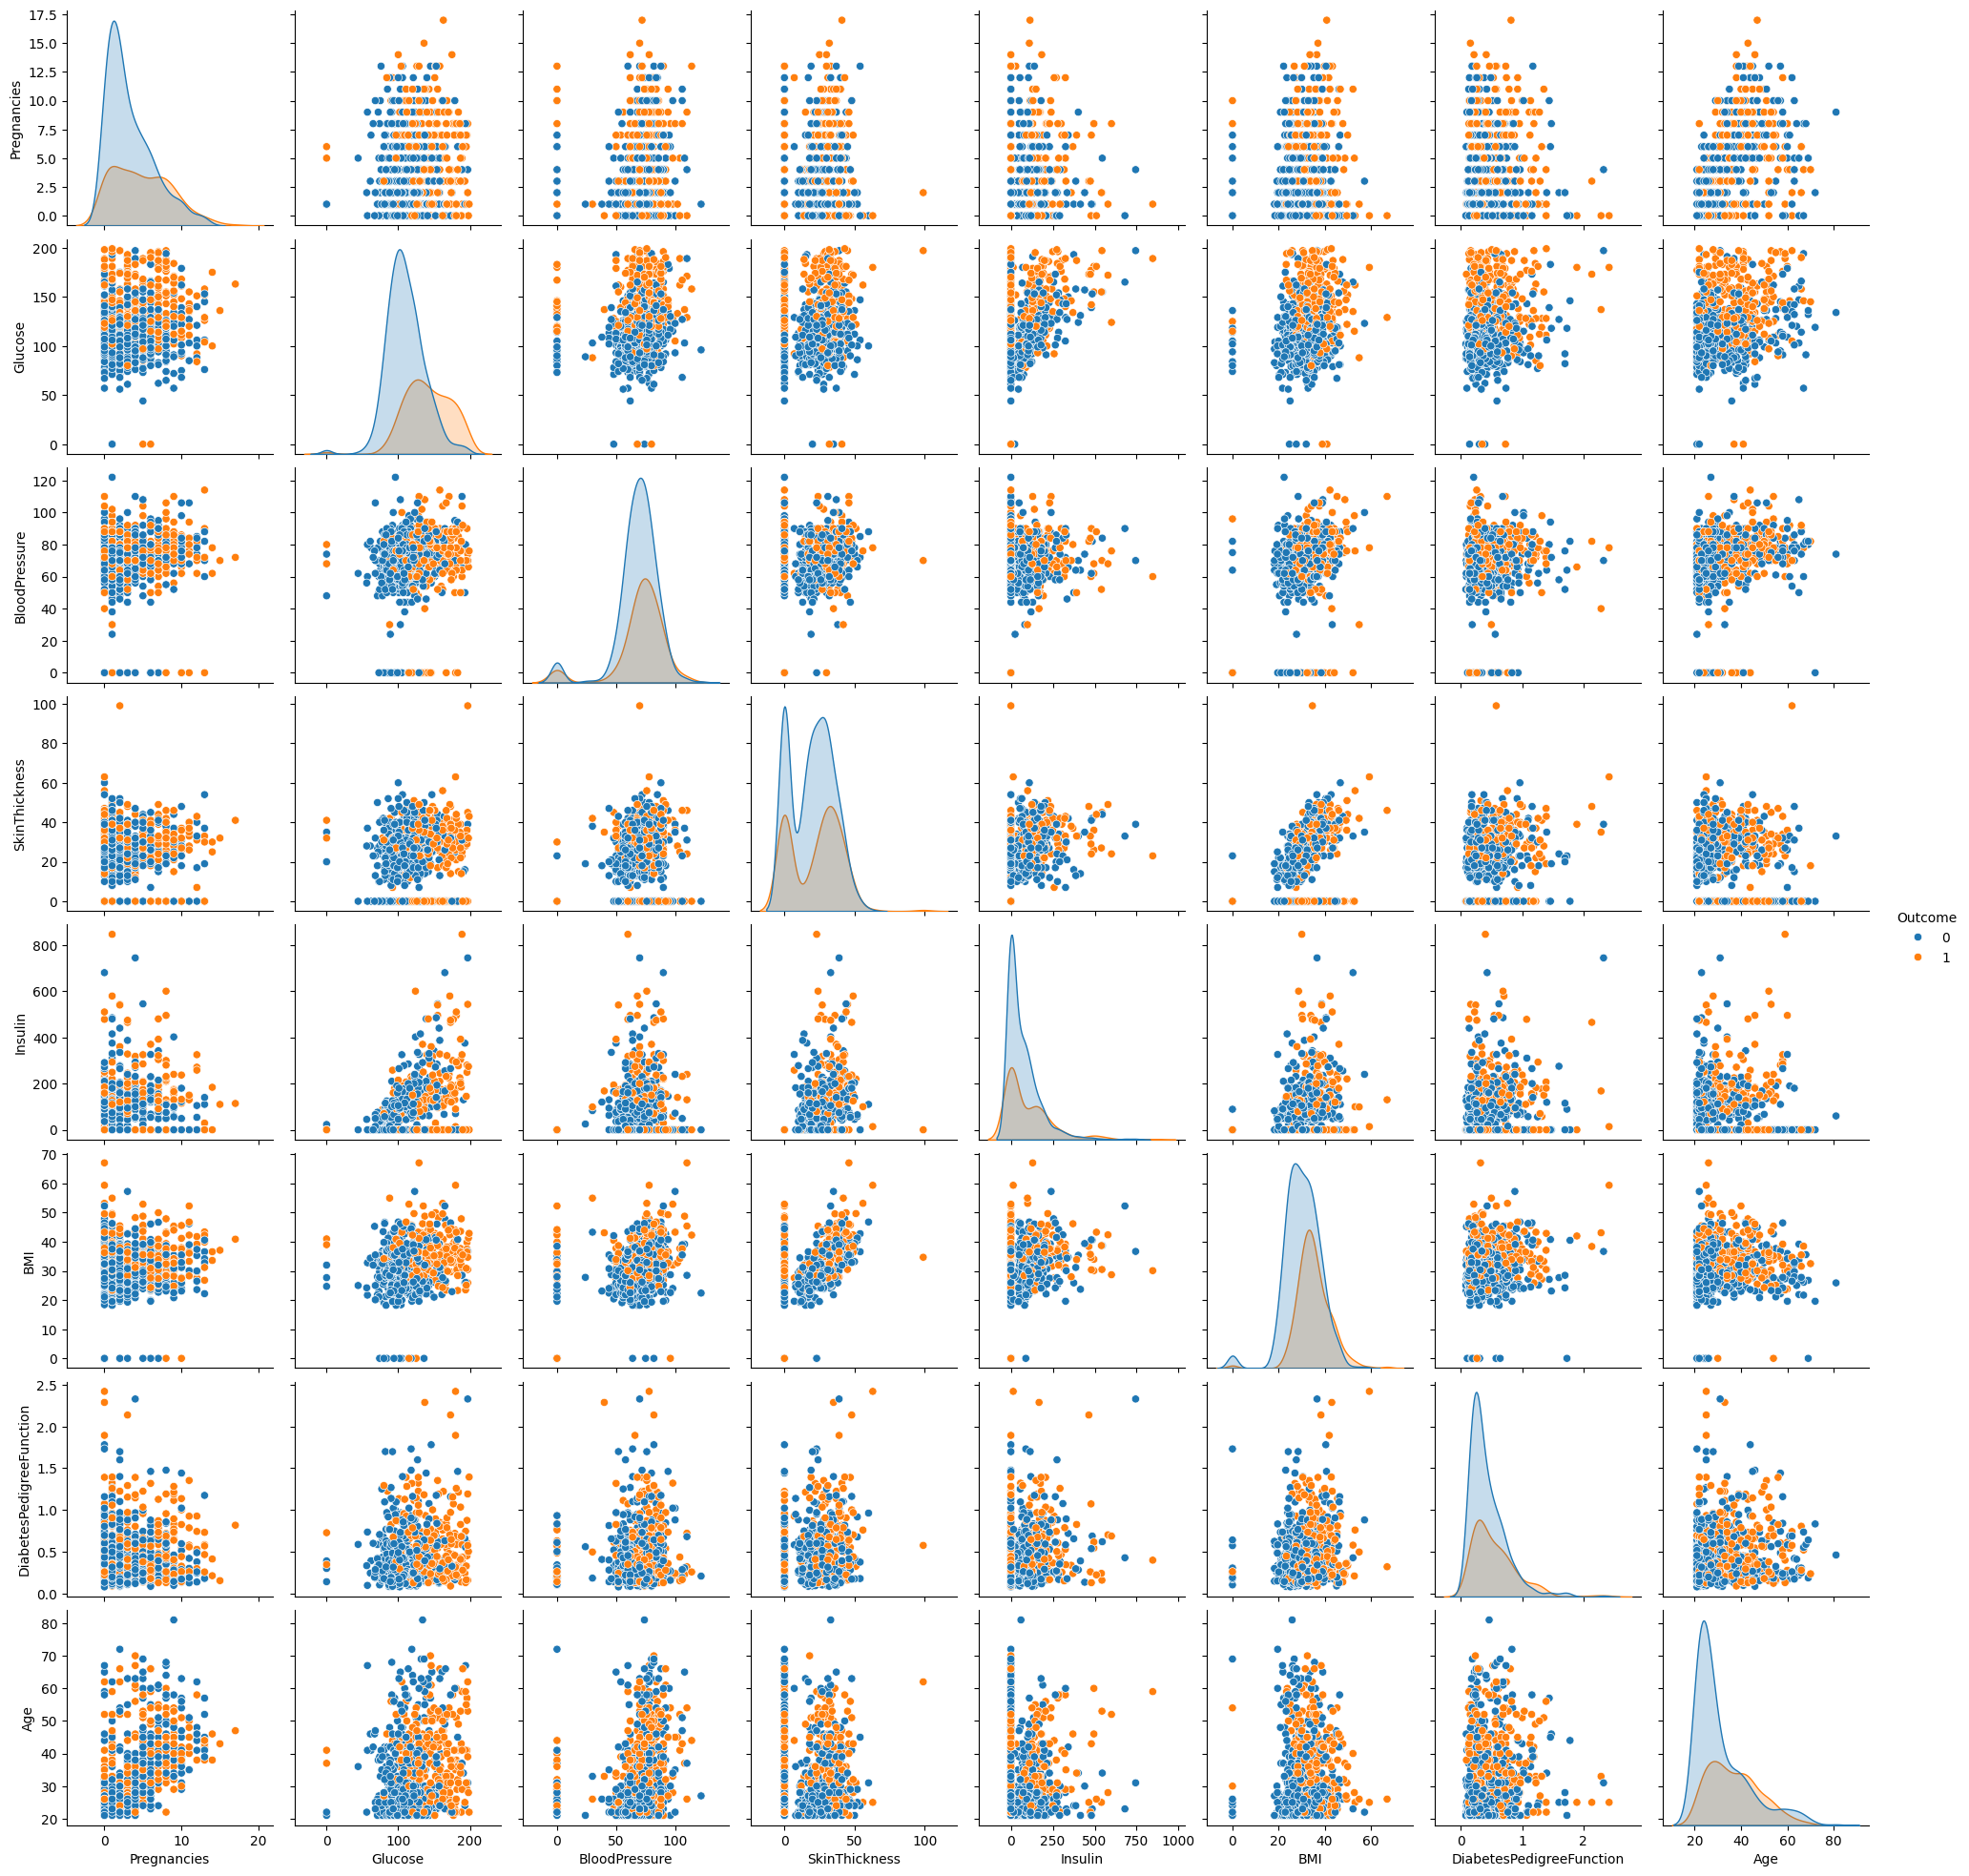

In [72]:
#df_temp = df.reset_index()

plt.figure(figsize=(4, 4))
sns.pairplot(data[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age','Outcome']],
             hue='Outcome',
             diag_kind='kde')
plt.show()

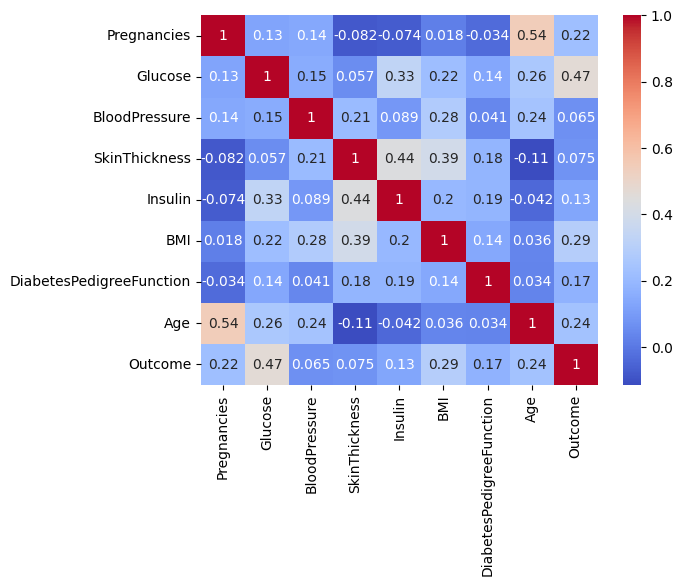

In [73]:
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

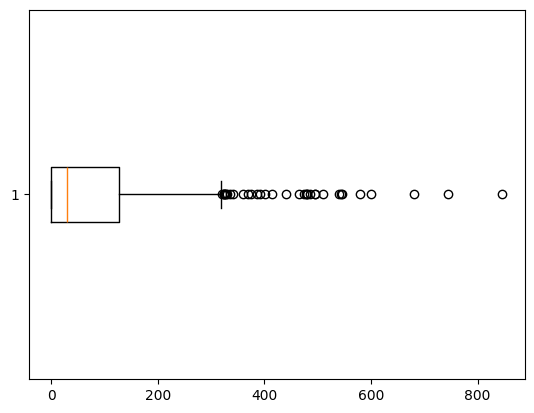

In [93]:
plt.boxplot(data['Insulin'], vert=False)
plt.show()

In [94]:
# Calculate the 0.95 percentile for the 'Insulin' feature
percentile_95 = data['Insulin'].quantile(0.95)
percentile_95

293.0

In [95]:
# Cap the 'Insulin' values at the 95th percentile
data['Insulin'] = np.where(data['Insulin'] > percentile_95, percentile_95, data['Insulin'])

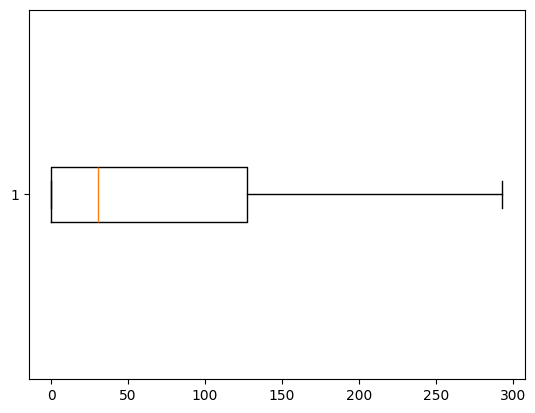

In [96]:
plt.boxplot(data['Insulin'], vert=False)
plt.show()

Test train split

In [97]:
# Split data into features (x) and target (y)
x = data.drop('Outcome', axis=1)
y = data['Outcome']

In [98]:
# Standardize the features
scaler = StandardScaler()
x_standardized = scaler.fit_transform(x)

# Convert back to DataFrame for convenience
x = pd.DataFrame(x_standardized, columns=x.columns)

In [99]:
x.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.848324,0.149641,0.907270,-0.800599,0.204013,0.468492,1.425995
1,-0.844885,-1.123396,-0.160546,0.530902,-0.800599,-0.684422,-0.365061,-0.190672
2,1.233880,1.943724,-0.263941,-1.288212,-0.800599,-1.103255,0.604397,-0.105584
3,-0.844885,-0.998208,-0.160546,0.154533,0.237960,-0.494043,-0.920763,-1.041549
4,-1.141852,0.504055,-1.504687,0.907270,1.055549,1.409746,5.484909,-0.020496


In [100]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [101]:
# Convert data to PyTorch tensors
x_train = torch.tensor(x_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)

In [102]:
x_test = torch.tensor(x_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.long)

In [103]:
x_train

tensor([[-0.5479, -1.1547, -3.5726,  ..., -4.0605, -0.5070, -1.0415],
        [ 1.5308, -0.2784,  0.6666,  ..., -0.4814,  2.4467,  1.4260],
        [-0.8449,  0.5666, -1.1945,  ..., -0.4179,  0.5500, -0.9565],
        ...,
        [ 1.8278, -0.6226,  0.8734,  ...,  1.7270,  2.0057,  0.4049],
        [-1.1419,  0.6292, -3.5726,  ...,  1.3209, -0.8060, -0.3608],
        [-1.1419,  0.1285,  1.3904,  ..., -1.2048, -0.6339, -1.0415]])

In [104]:
y_train

tensor([0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,

In [113]:
# Define the model
def build_model():
  # model = nn.Sequential(
  #     nn.Linear(in_features=8, out_features=24),
  #     nn.ReLU(),
  #     nn.Linear(in_features=24, out_features=48),
  #     nn.ReLU(),
  #     nn.Linear(in_features=48, out_features=6),
  #     nn.ReLU(),
  #     nn.Linear(6, 2)
  # )
  model = nn.Sequential(
    nn.Linear(in_features=8, out_features=24),
    nn.ReLU(),
    nn.BatchNorm1d(24),
    nn.Dropout(0.5),
    nn.Linear(in_features=24, out_features=48),
    nn.ReLU(),
    nn.BatchNorm1d(48),
    nn.Dropout(0.5),
    nn.Linear(in_features=48, out_features=6),
    nn.ReLU(),
    nn.Linear(6, 2)
    )
  return model

In [114]:
model = build_model()
# Pytorch models have 2 states:
model = model.train() # Used when we need to train the network which enables gradient tracking(for backwards operation) and collection of statistics(mean and var for batchnorm)
model = model.eval() # and model.eval() for evaluation mode, which disables gradient tracking and collection of statistics for efficiency during inference.

## Visualization of model available on
https://netron.app/

Saving the model and viewing it in netron app:

`torch.save(model, "model.pth")`

In [115]:
# training parameters
n_epochs = 50   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(x_train), batch_size)

In [ ]:
# If we have gpu
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [116]:
model = build_model()

In [117]:
# loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.MSELoss()  # mean square error
# Let's try different optimizers
# optimizer = optim.SGD(model.parameters(), lr=1.0) # Huge lr
# optimizer = optim.SGD(model.parameters(), lr=0.1) # Decrease it
# optimizer = optim.SGD(model.parameters(), lr=0.01) # Decrease it even more
# optimizer = optim.SGD(model.parameters(), lr=0.0001) # Is this good enough?
# optimizer = optim.Adam(model.parameters(), lr=1.0) # Huge lr with Adam
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
# optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [118]:
# Hold the best model
best_loss = np.inf   # init to infinity
# best_mse = np.inf
best_weights = None
history_val = []
history_train = []
acc_val = []
#acc_score = Accuracy(task="binary").to('cuda' if torch.cuda.is_available() else 'cpu')

# training loop
for epoch in range(n_epochs):
    model.train()
    # Ensure batch_start is correctly defined, e.g., range(0, len(X_train), batch_size)
    for start in tqdm.tqdm(range(0, len(x_train), batch_size), desc=f"Epoch {epoch}", unit="batch"):
        # take a batch
        x_batch = x_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        # forward pass
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
    # Evaluate loss on validation set at end of each epoch
    model.eval()
    # Get mse for training set(Usually you collect this in the 2nd for loop and
    # then average it out but here for simplicity we record the loss at the end of the epoch)
    y_pred_train = model(x_train)
    train_loss = loss_fn(y_pred_train, y_train).item()
    # mse = float(mse)
    history_train.append(train_loss)

    # Get mse for validation set
    y_pred = model(x_test)
    # print("y_pred", y_pred)
    # print("y_test", y_test)
    val_loss = loss_fn(y_pred, y_test).item()
    history_val.append(val_loss)
    # mse = loss_fn(y_pred, y_test)
    # mse = float(mse)
    # history_val.append(mse)

    if val_loss < best_loss:
        best_loss = val_loss
        best_weights = copy.deepcopy(model.state_dict())
    # calculating accuracy mse
    # y_pred = (y_pred > 0.5).float()
    # acc_epoch = Accuracy(task="binary")(y_pred, y_test)
    # acc_val.append(acc_epoch)
    # Calculate accuracy CE
    _, predicted_classes = torch.max(y_pred, 1)  # Get predicted class indices
    acc_epoch = Accuracy(task="multiclass", num_classes=2)(predicted_classes, y_test)
    acc_val.append(acc_epoch.item())

# restore the best model
model.load_state_dict(best_weights)

Epoch 49: 100%|██████████| 62/62 [00:00<00:00, 276.68batch/s]


<All keys matched successfully>

In [ ]:
acc_val


[0.6818181872367859,
 0.6818181872367859,
 0.6818181872367859,
 0.7337662577629089,
 0.7272727489471436,
 0.7077922224998474,
 0.6623376607894897,
 0.7272727489471436,
 0.6883116960525513,
 0.6818181872367859,
 0.6883116960525513,
 0.6948052048683167,
 0.6623376607894897,
 0.6753246784210205,
 0.6558441519737244,
 0.6428571343421936,
 0.6558441519737244,
 0.6688311696052551,
 0.6558441519737244,
 0.701298713684082,
 0.6623376607894897,
 0.6688311696052551,
 0.6818181872367859,
 0.6883116960525513,
 0.649350643157959,
 0.6623376607894897,
 0.6948052048683167,
 0.6623376607894897,
 0.6948052048683167,
 0.6688311696052551,
 0.6818181872367859,
 0.6883116960525513,
 0.6948052048683167,
 0.6883116960525513,
 0.7077922224998474,
 0.701298713684082,
 0.6688311696052551,
 0.6818181872367859,
 0.6753246784210205,
 0.701298713684082,
 0.6883116960525513,
 0.7207792401313782,
 0.6948052048683167,
 0.6948052048683167,
 0.6948052048683167,
 0.6948052048683167,
 0.701298713684082,
 0.707792222499847

Number of epochs: 30, Batch size: 10

Accuracy mean: 65.22%
Accuracy final: 65.58%
Best mse: 0.222
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


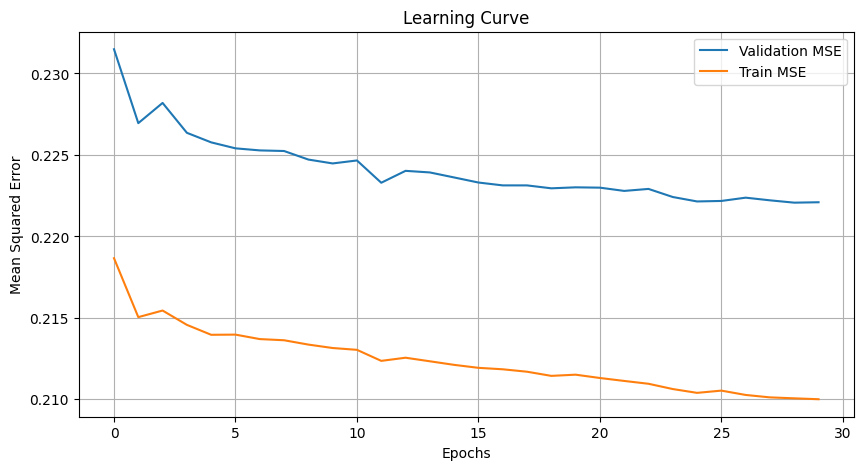

In [ ]:
# Calculating accuracy
acc = np.mean([val.cpu().item() for val in acc_val]) # Move tensors to CPU and convert to NumPy before calculating the mean
print(f"Accuracy mean: {acc:.2%}")
print(f"Accuracy final: {acc_val[-1]:.2%}")
print(f"Best mse: {best_mse:.3}")
print(f"Optimizer: {optimizer}")



# After the training loop with lr=0.01
plt.figure(figsize=(10, 5))
plt.plot(history_val, label='Validation MSE')
plt.plot(history_train, label="Train MSE")
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

Accuracy mean: 73.34%
Accuracy final: 75.32%
Best mse: 0.179
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Number of epochs: 40, Batch size: 8


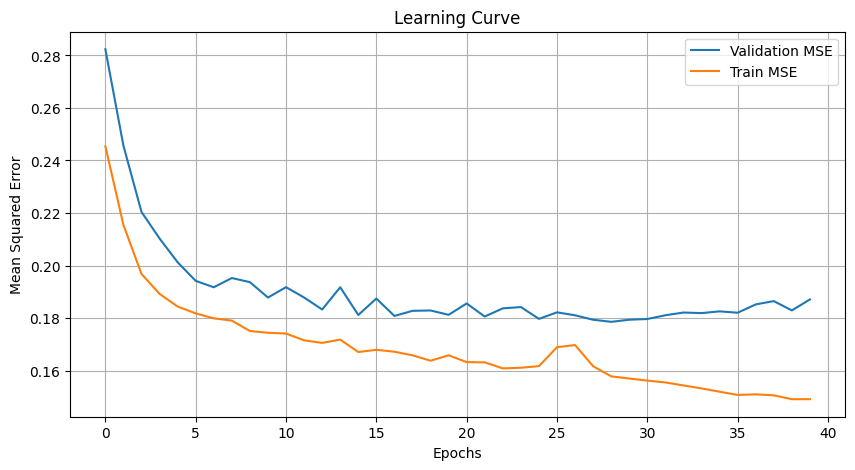

In [ ]:
# Calculating accuracy
acc = np.mean([val.cpu().item() for val in acc_val]) # Move tensors to CPU and convert to NumPy before calculating the mean
print(f"Accuracy mean: {acc:.2%}")
print(f"Accuracy final: {acc_val[-1]:.2%}")
print(f"Best mse: {best_mse:.3}")
print(f"Optimizer: {optimizer}")
print(f"Number of epochs: {n_epochs}, Batch size: {batch_size}")



# After the training loop with lr=0.01
plt.figure(figsize=(10, 5))
plt.plot(history_val, label='Validation MSE')
plt.plot(history_train, label="Train MSE")
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

Accuracy mean: 69.78%
Accuracy final: 72.73%
Best mse: 0.186
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Number of epochs: 50, Batch size: 6


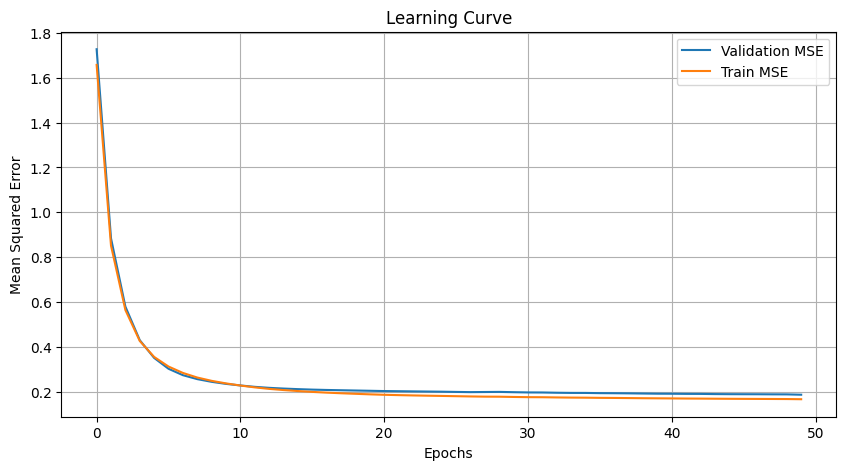

In [ ]:
# Calculating accuracy
acc = np.mean([val.cpu().item() for val in acc_val]) # Move tensors to CPU and convert to NumPy before calculating the mean
print(f"Accuracy mean: {acc:.2%}")
print(f"Accuracy final: {acc_val[-1]:.2%}")
print(f"Best mse: {best_mse:.3}")
print(f"Optimizer: {optimizer}")
print(f"Number of epochs: {n_epochs}, Batch size: {batch_size}")



# After the training loop with lr=0.01
plt.figure(figsize=(10, 5))
plt.plot(history_val, label='Validation MSE')
plt.plot(history_train, label="Train MSE")
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

Accuracy mean: 70.42%
Accuracy final: 72.08%
Best mse: 0.605
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Number of epochs: 100, Batch size: 10


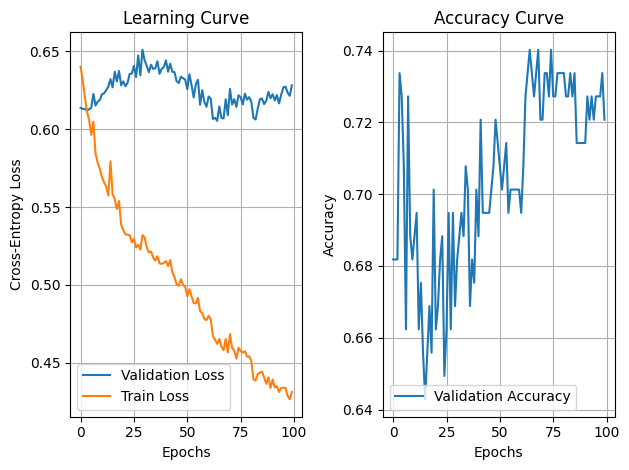

In [ ]:
# Calculating accuracy
acc = np.mean(acc_val)
print(f"Accuracy mean: {acc:.2%}")
print(f"Accuracy final: {acc_val[-1]:.2%}")
print(f"Best mse: {best_loss:.3}")
print(f"Optimizer: {optimizer}")
print(f"Number of epochs: {n_epochs}, Batch size: {batch_size}")


# Plot Cross-Entropy Loss
plt.subplot(1, 2, 1)
plt.plot(history_val, label='Validation Loss')
plt.plot(history_train, label='Train Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(acc_val, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Accuracy mean: 64.53%
Accuracy final: 71.43%
Best mse: 0.636
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Number of epochs: 50, Batch size: 8


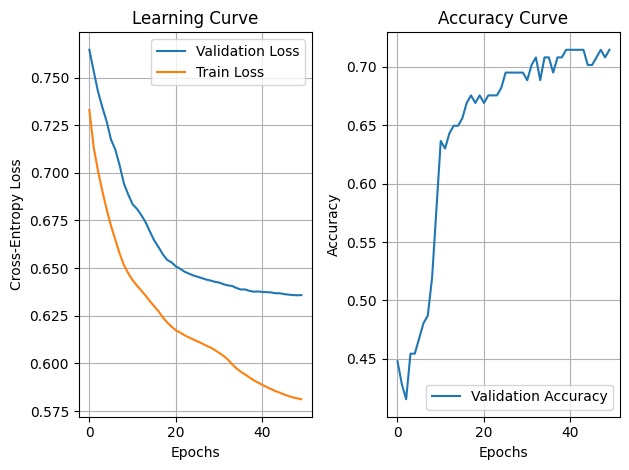

In [24]:
# Calculating accuracy
acc = np.mean(acc_val)
print(f"Accuracy mean: {acc:.2%}")
print(f"Accuracy final: {acc_val[-1]:.2%}")
print(f"Best mse: {best_loss:.3}")
print(f"Optimizer: {optimizer}")
print(f"Number of epochs: {n_epochs}, Batch size: {batch_size}")


# Plot Cross-Entropy Loss
plt.subplot(1, 2, 1)
plt.plot(history_val, label='Validation Loss')
plt.plot(history_train, label='Train Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(acc_val, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Accuracy mean: 73.66%
Accuracy final: 75.32%
Best loss: 0.498
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Number of epochs: 100, Batch size: 10


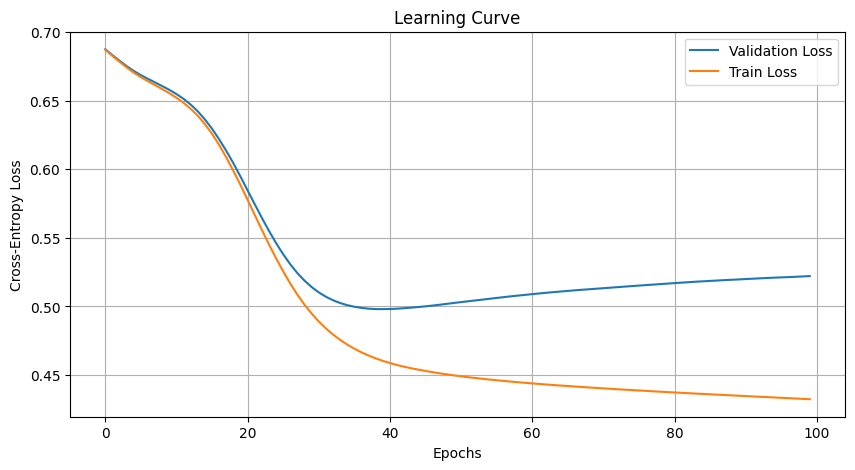

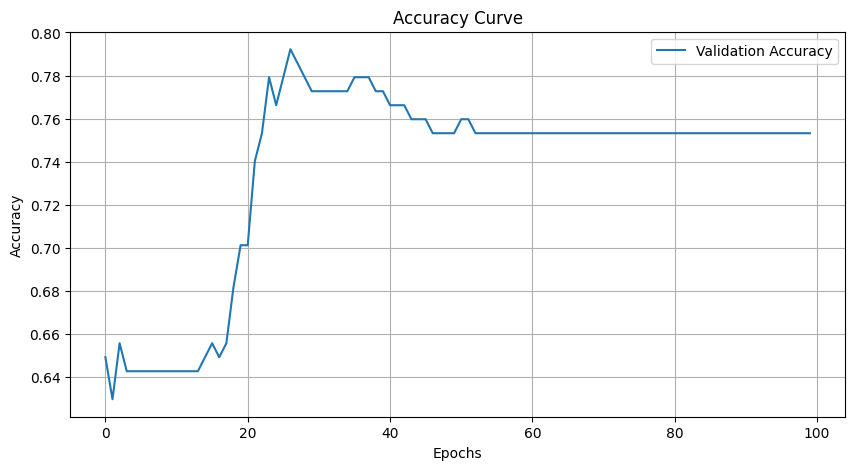

In [62]:
# Calculating accuracy
acc = np.mean(acc_val)
print(f"Accuracy mean: {acc:.2%}")
print(f"Accuracy final: {acc_val[-1]:.2%}")
print(f"Best loss: {best_loss:.3}")
print(f"Optimizer: {optimizer}")
print(f"Number of epochs: {n_epochs}, Batch size: {batch_size}")

# Plot Cross-Entropy Loss
plt.figure(figsize=(10, 5))
#plt.subplot(1, 2, 1)
plt.plot(history_val, label='Validation Loss')
plt.plot(history_train, label='Train Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.grid(True)
plt.show()


# Plot Accuracy
plt.figure(figsize=(10, 5))
#plt.subplot(1, 2, 2)
plt.plot(acc_val, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Accuracy mean: 72.30%
Accuracy final: 75.32%
Best loss: 0.53
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Number of epochs: 50, Batch size: 10


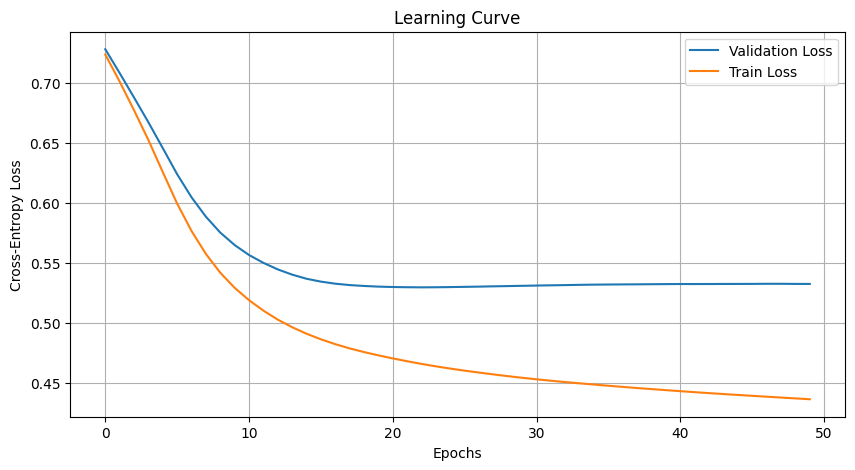

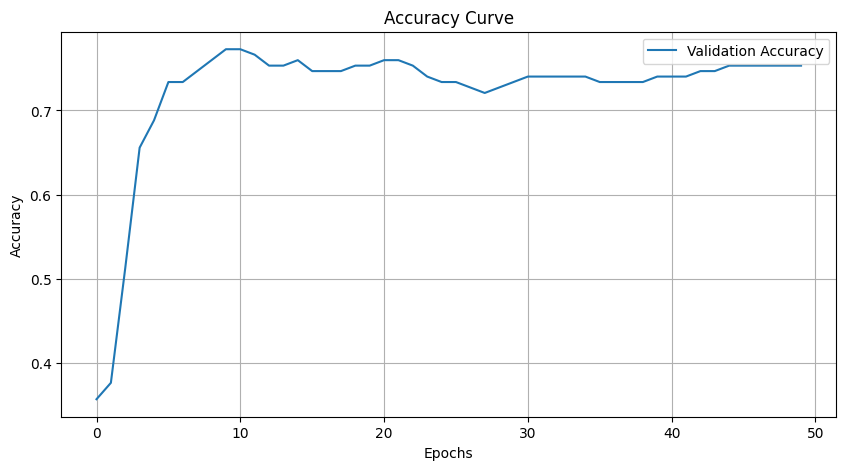

In [112]:
# Calculating accuracy
acc = np.mean(acc_val)
print(f"Accuracy mean: {acc:.2%}")
print(f"Accuracy final: {acc_val[-1]:.2%}")
print(f"Best loss: {best_loss:.3}")
print(f"Optimizer: {optimizer}")
print(f"Number of epochs: {n_epochs}, Batch size: {batch_size}")

# Plot Cross-Entropy Loss
plt.figure(figsize=(10, 5))
#plt.subplot(1, 2, 1)
plt.plot(history_val, label='Validation Loss')
plt.plot(history_train, label='Train Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.grid(True)
plt.show()


# Plot Accuracy
plt.figure(figsize=(10, 5))
#plt.subplot(1, 2, 2)
plt.plot(acc_val, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Accuracy mean: 75.87%
Accuracy final: 79.87%
Best loss: 0.529
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0001
)
Number of epochs: 50, Batch size: 10


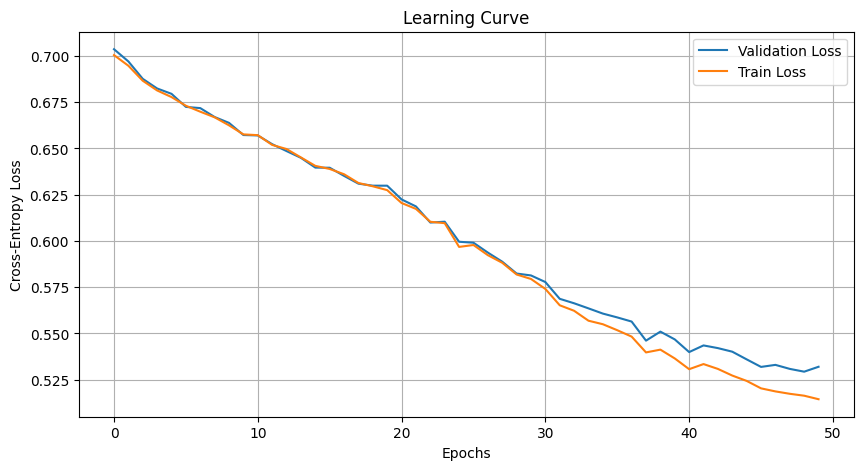

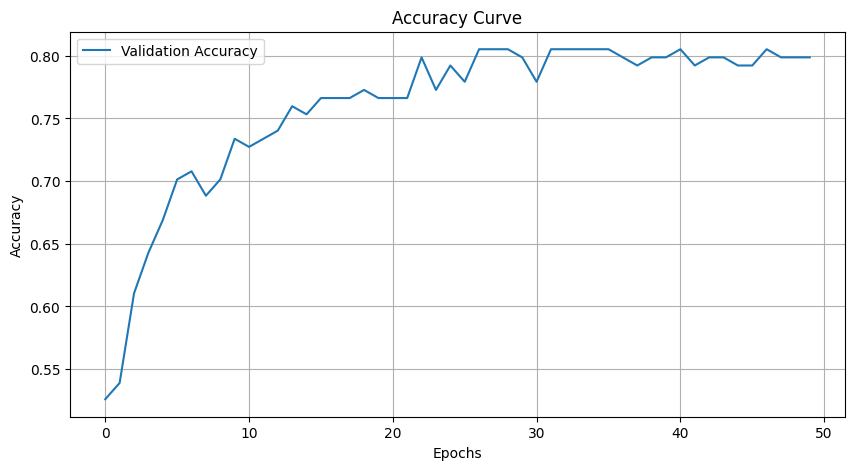

In [119]:
# Calculating accuracy
acc = np.mean(acc_val)
print(f"Accuracy mean: {acc:.2%}")
print(f"Accuracy final: {acc_val[-1]:.2%}")
print(f"Best loss: {best_loss:.3}")
print(f"Optimizer: {optimizer}")
print(f"Number of epochs: {n_epochs}, Batch size: {batch_size}")

# Plot Cross-Entropy Loss
plt.figure(figsize=(10, 5))
#plt.subplot(1, 2, 1)
plt.plot(history_val, label='Validation Loss')
plt.plot(history_train, label='Train Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.grid(True)
plt.show()


# Plot Accuracy
plt.figure(figsize=(10, 5))
#plt.subplot(1, 2, 2)
plt.plot(acc_val, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

ToDo:
- standardaze the data
- Optionally: do the Descriptive analysis
  - analyze for outliers
- Optimize cross-entrophy (?) instead of MSE

<h3 align="center">Task N2.1 - 1D Convolution operation</h3>

- **Convolution** is an operation when we have 2 functions and by merging them together we get a third function. For images, first "function" is the pixel values of the image and the second "function" is the filter itself. For 1D data(Like time-series or text) we have 1D Convolution kernels, for 2D/3D data we have appropriate kernels as well

- For time series data we can see on the below image how convolution operation is done on 1D data. It is often used for denoising the data. For example you can use an averaging kernel( 1/n, 1/n ... 1/n ) for denoising. Explain what tradeoff is between using large kernels and smaller kernels by observing the outputs.

![Image alt text](https://i.stack.imgur.com/WNIXd.png)

- Your task is to build a sliding window 1D convolution on a sine function with some noise added to it. Below you can see the code for initializing it and plotting the noisy data. Your task is to denoise the `noisy_signal` variable. Write a function which will take in the `noisy_signal` and denoise it with 1D convolution.
```
N = 1000  # Number of data points
t = np.linspace(0, 4*np.pi, N)  # Time variable
clean_signal = np.sin(t)  # Clean sin function
noise = np.random.normal(0, 0.5, N)
noisy_signal = clean_signal + noise
plt.plot(t, noisy_signal)
plt.title('Noisy Signal')
plt.show()
```

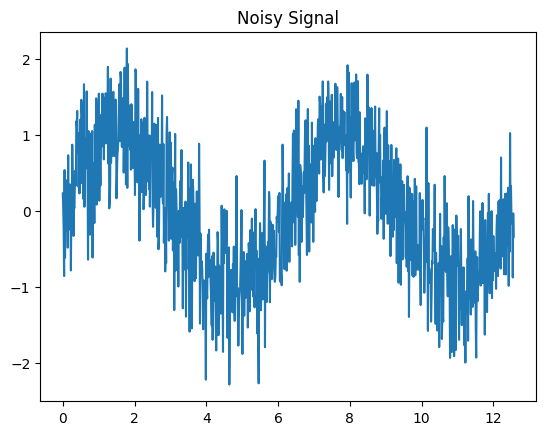

In [ ]:
N = 1000  # Number of data points
t = np.linspace(0, 4*np.pi, N)  # Time variable
clean_signal = np.sin(t)  # Clean sin function
noise = np.random.normal(0, 0.5, N)
noisy_signal = clean_signal + noise
plt.plot(t, noisy_signal)
plt.title('Noisy Signal')
plt.show()


<h3 align="center">Task N2.2 - 2D Convolution operation</h3>

- In image processing **Convolution** filter/kernel is a $k \times k$ matrix which is used for retrieving useful features from the image. It is a fundamental building block of Convolutional neural networks(CNN)

- After applying the kernel over the image, we often get a downsampled feature map from the image as shown in the animation below:
  
<center><img src="https://drive.google.com/uc?export=view&id=153Aj-MSmLndc3dNhl9HvbpNZhDGlYB_I" alt="Example" /></center>


- Your job is to write a convolution operation as a function(without using packages like torch,tensorflow, keras etc.) which takes in image of shape (**CxHxW**, C - Channel(usually RGB), H - Height of the image, W - Width of the image) and get the output image after applying convolution like it's shown in the illustration. Keep dimensions of the image in mind, if kernel is larger than the image, 28x28 image let's say and user inputs kernel size of 30x30, then return an error. Implementing padding in this task is not needed.

- For testing the output you can use the **uniform blur** kernel for any image you like which is defined below:
  \begin{equation}
K = \frac{1}{9} \begin{bmatrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1
\end{bmatrix}
\end{equation}

- Try your function on grayscale images with Sobel Operator and explain the output:
\begin{equation}
K = \begin{bmatrix}
-1 & 0 &  1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}
\end{equation}

In [ ]:
# Write your code here